In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Leer datos

In [2]:
df = pd.read_csv('datasets/preprocess/df_time_monthly', parse_dates=True)
df['date'] = pd.to_datetime(df['date'])
df.dtypes

date             datetime64[ns]
cost                      int64
holidays_cont             int64
month                     int64
year                      int64
days_in_month             int64
is_year_start              bool
is_year_end               int64
dtype: object

In [3]:
df.tail()

,date,cost,holidays_cont,month,year,days_in_month,is_year_start,is_year_end
38,2022-11-30,4466767,2,11,2022,30,False,0
39,2022-12-31,2901875,2,12,2022,31,False,1
40,2023-01-31,2962677,1,1,2023,31,False,0
41,2023-02-28,2505194,0,2,2023,28,False,0
42,2023-03-31,2882122,1,3,2023,31,False,0


# 2 Exploratory Data Analysis for Time Series (EDA)
Basado en el libro:
 Aileen Nielsen - Practical Time Series Analysis_ Prediction with Statistics and Machine Learning-O’Reilly Media (2019).pdf

In [4]:
df = df.set_index('date')
df.head()

,cost,holidays_cont,month,year,days_in_month,is_year_start,is_year_end
date,,,,,,,
2019-09-30,1440500,0,9,2019,30,False,0
2019-10-31,1943400,1,10,2019,31,False,0
2019-11-30,1437850,2,11,2019,30,False,0
2019-12-31,1298200,1,12,2019,31,False,1
2020-01-31,4037250,2,1,2020,31,False,0


# 2.1 Plot

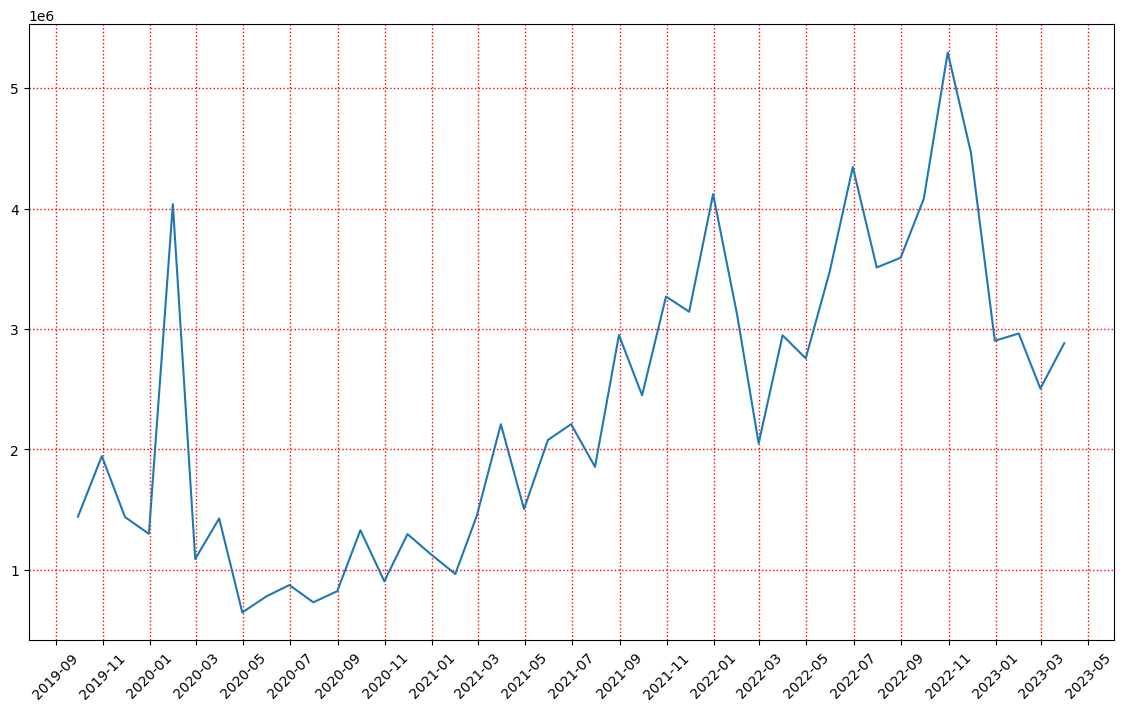

In [5]:
# dates = pd.to_datetime(df['date'])
# # Crear un gráfico de línea con los valores de 'cost'
# plt.plot(dates, df['cost'])

# # Agregar una etiqueta al eje Y
# plt.ylabel('Costo (Pesos colombianos)')

# # Agregar una etiqueta de título
# plt.title('Serie de tiempo de los gastos de una familia colombiana')
# # ajusta los límites del eje x
# plt.xlim(df['date'].min(), df['date'].max() + pd.DateOffset(days=30))

# # Mostrar el gráfico
# plt.show()

# Establecer la columna 'date' como el índice del DataFrame
# df.set_index('date', inplace=True)

# Crear el gráfico
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(df.index, df['cost'])

# Establecer el formato del eje x para que muestre cada mes
ax.xaxis.set_major_locator(dates.MonthLocator(interval=2))

# Establecer el formato de las etiquetas del eje x
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m'))
# trazar cuadricula
plt.grid(color='r', linestyle='dotted', linewidth=1)
plt.xticks(rotation = 45)

# Mostrar el gráfico
plt.show()

De la anterior puedo observar que hay un gran pico  en Feb 2020 y Nov 2022 (debido a las vacaciones en Suiza) y otro pico leve en Ene 2022 (creo viaje a medellín) considerar esos picos para un análisis de datos anómalos

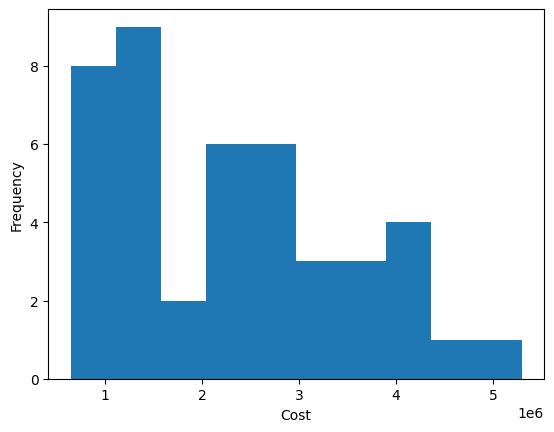

In [8]:
df['cost'].plot(kind='hist', bins=10)
plt.xlabel('Cost')
plt.show()

Observar la relación entre la variable 'cost' y las demás variables usando una matriz de correlación

In [10]:
corr_matrix = df.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

/home/bitsamericas/Documents/5-cursos/11-Platzi/platzi-curso-Machine-Learning-con-Scikit-Learn/entorno/lib/python3.9/site-packages/pandas/io/formats/style.py:3618: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/bitsamericas/Documents/5-cursos/11-Platzi/platzi-curso-Machine-Learning-con-Scikit-Learn/entorno/lib/python3.9/site-packages/pandas/io/formats/style.py:3619: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,cost,holidays_cont,month,year,days_in_month,is_year_start,is_year_end
cost,1.000000,0.049301,0.099143,0.646793,0.141118,nan,0.007814
holidays_cont,0.049301,1.000000,0.176007,-0.059122,0.455079,nan,0.149857
month,0.099143,0.176007,1.000000,-0.345187,0.244505,nan,0.482671
year,0.646793,-0.059122,-0.345187,1.000000,-0.104682,nan,-0.132186
days_in_month,0.141118,0.455079,0.244505,-0.104682,1.000000,nan,0.221209
is_year_start,nan,nan,nan,nan,nan,nan,nan
is_year_end,0.007814,0.149857,0.482671,-0.132186,0.221209,nan,1.000000


## 2.2 Especificos metodos de exploración

- **Stationarity**: is one that has fairly stable statistical properties over time, particularly with respect to mean and variance.
Un número grande de modelos asume procesos estacionarios
- Self-correlation
- Spurious correlations

ADF test¶
**ADF test** is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:

Null Hypothesis: The series has a unit root.

Alternate Hypothesis: The series has no unit root.

If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary

In [22]:
adf = adfuller(df['cost'])

print('ADF Statistic: %f' % adf[0])
print('p-value: %f' % adf[1])
print('Critical Values:')
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.540805
p-value: 0.105859
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605


In [23]:
def test_is_stationary(df):
  adf = adfuller(df['cost'])
  p_value = adf[1]
  print('ADF Statistic: %f' % adf[0])
  print('p-value: %f' % p_value)
  print('Critical Values:')
  for key, value in adf[4].items():
      print('\t%s: %.3f' % (key, value))
# Este valor nos indica la probabilidad de que la hipótesis nula no sea rechazada. existe un 10.5 % de que no sea estacionaria
# Si el valor p es menor que el nivel de significancia, se rechaza la hipótesis nula de que la serie de tiempo tiene una raíz unitaria y se concluye que la serie es estacionaria.
  if p_value < 0.05: # Es estacionaria
    return True
  else:
    return False

In [24]:
is_statitonary = test_is_stationary(df)
is_statitonary

P values 0.10585892575426309


False

### Realizar un descomposición de la serie de tiempo en sus componentes de tendencia, estacionalidad y residuo:
En el análisis exploratorio de series de tiempo, se pueden identificar dos tipos de modelos: aditivo y multiplicativo.

Un modelo aditivo se utiliza cuando los cambios en la serie a lo largo del tiempo son uniformes, es decir, la magnitud de la variación es constante independientemente del nivel de la serie. En este modelo, la serie se descompone en tres componentes: tendencia, estacionalidad y residuos, que se suman para obtener la serie original.

Por otro lado, un modelo multiplicativo se utiliza cuando los cambios en la serie a lo largo del tiempo son proporcionales al nivel de la serie. En este modelo, la serie se descompone en tres componentes: tendencia, estacionalidad y residuos, que se multiplican para obtener la serie original.

En el caso del dataset que mencionaste, se escogió el modelo aditivo debido a que la magnitud de la variación en la variable "cost" parecía ser constante a lo largo del tiempo. Sin embargo, esta elección puede variar dependiendo de la serie de tiempo y es necesario realizar un análisis detallado para determinar el modelo adecuado

<Figure size 1000x800 with 0 Axes>

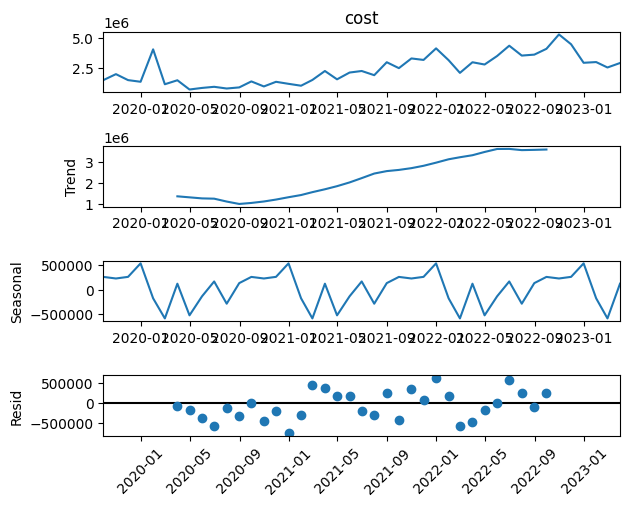

In [15]:
result = seasonal_decompose(df['cost'], model='additive')
# Crear la figura con un tamaño más grande
fig = plt.figure(figsize=(10, 8))

# Graficar los componentes de la descomposición
result.plot()

# Cambiar la rotación de las etiquetas del eje X a 45 grados
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.show()

/tmp/ipykernel_6064/2225140748.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


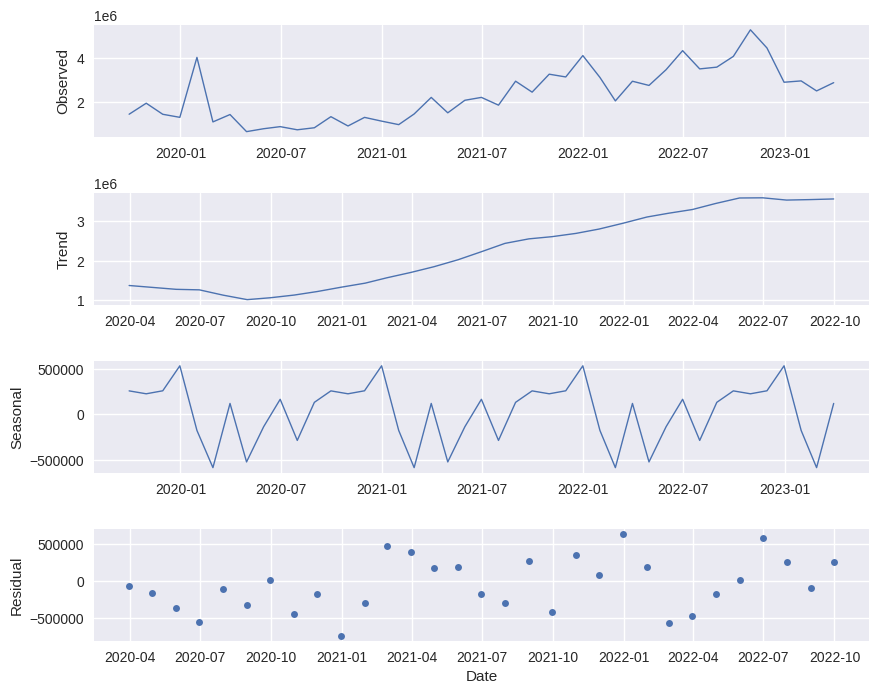

In [20]:
# Aplicar la descomposición estacional
result = seasonal_decompose(df['cost'], model='additive')

# Establecer el estilo de la gráfica
plt.style.use('seaborn')

# Configurar el tamaño de los puntos en la gráfica de residual
plt.rc('lines', linewidth=1)
plt.rc('lines', markersize=5)

# Crear la figura con un tamaño más grande
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

# Graficar los componentes de la descomposición
ax1.plot(result.observed)
ax1.set_ylabel('Observed')
ax2.plot(result.trend)
ax2.set_ylabel('Trend')
ax3.plot(result.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(result.resid, marker='o', linestyle='none')
ax4.set_ylabel('Residual')

# Etiquetas del eje X para cada subgráfica
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('Date')

# Ajustar la distancia entre las subgráficas
plt.subplots_adjust(hspace=0.5)

# Mostrar la gráfica
plt.show()

**6** Realizar una autocorrelación simple y parcial para analizar la correlación entre la serie de tiempo y sus rezagos:

In [28]:
# Find the optimal lag length using the VAR model and AIC/BIC criteria
# from statsmodels.tsa.api import VAR
# model = VAR(df)
# res = model.fit(maxlags=20, ic='aic')
# print(res.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen werecost             int64
holidays_cont    int64
month            int64
year             int64
days_in_month    int64
is_year_start     bool
is_year_end      int64
dtype: object and None. The data was
               cost  holidays_cont  month  year  days_in_month  is_year_start   
date                                                                            
2019-09-30  1440500              0      9  2019             30          False  \
2019-10-31  1943400              1     10  2019             31          False   
2019-11-30  1437850              2     11  2019             30          False   
2019-12-31  1298200              1     12  2019             31          False   
2020-01-31  4037250              2      1  2020             31          False   
2020-02-29  1089346              0      2  2020             29          False   
2020-03-31  1426000              1      3  2020             31          False   
2020-04-30   645200              2      4  2020             30          False   
2020-05-31   778000              2      5  2020             31          False   
2020-06-30   872971              3      6  2020             30          False   
2020-07-31   729500              1      7  2020             31          False   
2020-08-31   822100              2      8  2020             31          False   
2020-09-30  1328400              0      9  2020             30          False   
2020-10-31   903750              1     10  2020             31          False   
2020-11-30  1296050              2     11  2020             30          False   
2020-12-31  1124900              2     12  2020             31          False   
2021-01-31   965000              2      1  2021             31          False   
2021-02-28  1452000              0      2  2021             28          False   
2021-03-31  2208550              1      3  2021             31          False   
2021-04-30  1504800              2      4  2021             30          False   
2021-05-31  2077950              2      5  2021             31          False   
2021-06-30  2209200              2      6  2021             30          False   
2021-07-31  1854810              2      7  2021             31          False   
2021-08-31  2949470              2      8  2021             31          False   
2021-09-30  2449092              0      9  2021             30          False   
2021-10-31  3269372              1     10  2021             31          False   
2021-11-30  3143335              2     11  2021             30          False   
2021-12-31  4119692              2     12  2021             31          False   
2022-01-31  3121610              1      1  2022             31          False   
2022-02-28  2049788              0      2  2022             28          False   
2022-03-31  2947435              1      3  2022             31          False   
2022-04-30  2756124              2      4  2022             30          False   
2022-05-31  3475179              2      5  2022             31          False   
2022-06-30  4345208              2      6  2022             30          False   
2022-07-31  3511116              2      7  2022             31          False   
2022-08-31  3591612              2      8  2022             31          False   
2022-09-30  4082624              0      9  2022             30          False   
2022-10-31  5296946              1     10  2022             31          False   
2022-11-30  4466767              2     11  2022             30          False   
2022-12-31  2901875              2     12  2022             31          False   
2023-01-31  2962677              1      1  2023             31          False   
2023-02-28  2505194              0      2  2023             28          False   
2023-03-31  2882122              1      3  2023             31          False   

            is_year_end  
date                     
2019-09-30            0  
2019-10-31            0  
2019-11-30            0  
2019-12-31            1  
2020-01-31            0  
2020-02-29            0  
2020-03-31            0  
2020-04-30            0  
2020-05-31            0  
2020-06-30            0  
2020-07-31            0  
2020-08-31            0  
2020-09-30            0  
2020-10-31            0  
2020-11-30            0  
2020-12-31            1  
2021-01-31            0  
2021-02-28            0  
2021-03-31            0  
2021-04-30            0  
2021-05-31            0  
2021-06-30            0  
2021-07-31            0  
2021-08-31            0  
2021-09-30            0  
2021-10-31            0  
2021-11-30            0  
2021-12-31            1  
2022-01-31            0  
2022-02-28            0  
2022-03-31            0  
2022-04-30            0  
2022-05-31            0  
2022-06-30            0  
2022-07-31            0  
2022-08-31            0  
2022-09-30            0  
2022-10-31            0  
2022-11-30            0  
2022-12-31            1  
2023-01-31            0  
2023-02-28            0  
2023-03-31            0  
and
 None
before. After,
[[1440500 0 9 2019 30 False 0]
 [1943400 1 10 2019 31 False 0]
 [1437850 2 11 2019 30 False 0]
 [1298200 1 12 2019 31 False 1]
 [4037250 2 1 2020 31 False 0]
 [1089346 0 2 2020 29 False 0]
 [1426000 1 3 2020 31 False 0]
 [645200 2 4 2020 30 False 0]
 [778000 2 5 2020 31 False 0]
 [872971 3 6 2020 30 False 0]
 [729500 1 7 2020 31 False 0]
 [822100 2 8 2020 31 False 0]
 [1328400 0 9 2020 30 False 0]
 [903750 1 10 2020 31 False 0]
 [1296050 2 11 2020 30 False 0]
 [1124900 2 12 2020 31 False 1]
 [965000 2 1 2021 31 False 0]
 [1452000 0 2 2021 28 False 0]
 [2208550 1 3 2021 31 False 0]
 [1504800 2 4 2021 30 False 0]
 [2077950 2 5 2021 31 False 0]
 [2209200 2 6 2021 30 False 0]
 [1854810 2 7 2021 31 False 0]
 [2949470 2 8 2021 31 False 0]
 [2449092 0 9 2021 30 False 0]
 [3269372 1 10 2021 31 False 0]
 [3143335 2 11 2021 30 False 0]
 [4119692 2 12 2021 31 False 1]
 [3121610 1 1 2022 31 False 0]
 [2049788 0 2 2022 28 False 0]
 [2947435 1 3 2022 31 False 0]
 [2756124 2 4 2022 30 False 0]
 [3475179 2 5 2022 31 False 0]
 [4345208 2 6 2022 30 False 0]
 [3511116 2 7 2022 31 False 0]
 [3591612 2 8 2022 31 False 0]
 [4082624 0 9 2022 30 False 0]
 [5296946 1 10 2022 31 False 0]
 [4466767 2 11 2022 30 False 0]
 [2901875 2 12 2022 31 False 1]
 [2962677 1 1 2023 31 False 0]
 [2505194 0 2 2023 28 False 0]
 [2882122 1 3 2023 31 False 0]]
None.

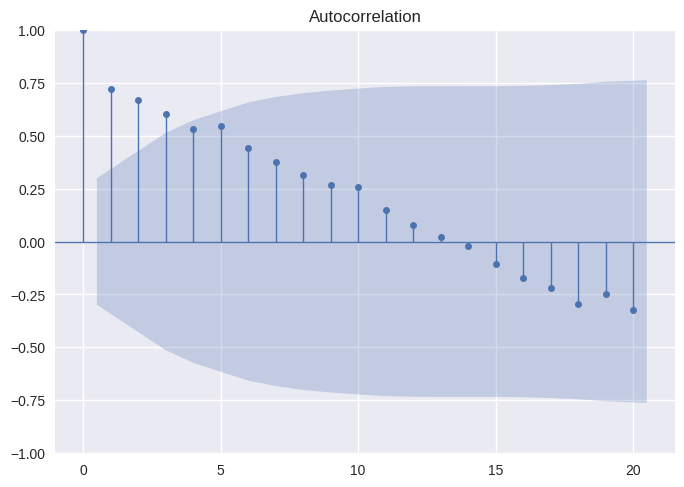

/home/bitsamericas/Documents/5-cursos/11-Platzi/platzi-curso-Machine-Learning-con-Scikit-Learn/entorno/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


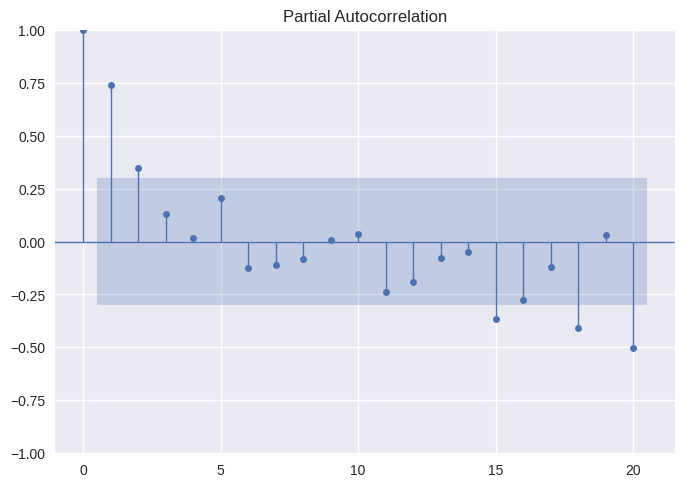

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['cost'], lags=20)
plt.show()

plot_pacf(df['cost'], lags=20)
plt.show()

En el punto 6, elegimos un valor de lags=20 para incluir suficiente información pasada en el modelo VAR, lo que puede mejorar su capacidad para hacer pronósticos precisos. Sin embargo, la elección del valor de lags puede variar dependiendo del conjunto de datos y del contexto del problema en cuestión.

Una forma común de seleccionar el valor adecuado de lags es mediante la técnica de "lag length selection" o "selección de longitud de retardo", que implica probar diferentes valores de lags y seleccionar aquel que proporcione el mejor desempeño del modelo en términos de criterios de información como el AIC (Akaike Information Criterion) o el BIC (Bayesian Information Criterion).

Para implementar esta técnica, se puede utilizar un bucle que ajuste modelos VAR con diferentes valores de lags, evalúe su desempeño utilizando criterios de información y seleccione aquel que proporcione el valor mínimo del criterio. Por ejemplo:

In [26]:
import statsmodels.api as sm

# Define un rango de valores de lags para probar
lags_range = range(1, 30)

# Inicializa los valores mínimos de AIC y BIC como infinito
min_aic, min_bic = float("inf"), float("inf")

# Inicializa el valor óptimo de lags como cero
optimal_lags = 0

# Itera sobre cada valor de lags y ajusta un modelo VAR
for lags in lags_range:
    model = sm.tsa.VAR(endog_data)
    results = model.fit(lags)

    # Evalúa el desempeño del modelo en términos de AIC y BIC
    aic = results.aic
    bic = results.bic

    # Actualiza los valores mínimos y el valor óptimo de lags
    if aic < min_aic:
        min_aic = aic
        optimal_lags = lags

    if bic < min_bic:
        min_bic = bic
        optimal_lags = lags

print("El valor óptimo de lags es:", optimal_lags)

NameError: name 'endog_data' is not defined

### Convertir no estacionario en estacionario

ADF Statistic: -9.594888
p-value: 0.000000
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606


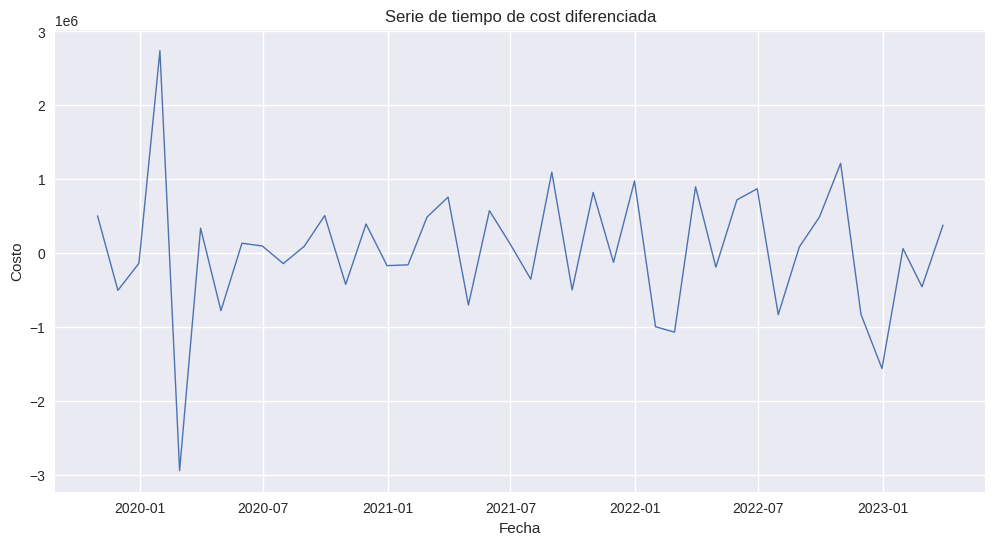

In [29]:
df['cost_diff'] = df['cost'].diff()
df.dropna(inplace=True)

result = adfuller(df['cost_diff'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

plt.figure(figsize=(12,6))
plt.plot(df['cost_diff'])
plt.title('Serie de tiempo de cost diferenciada')
plt.xlabel('Fecha')
plt.ylabel('Costo')
plt.show()


In [31]:
df.tail()

,cost,holidays_cont,month,year,days_in_month,is_year_start,is_year_end,cost_diff
date,,,,,,,,
2022-11-30,4466767,2,11,2022,30,False,0,-830179.0
2022-12-31,2901875,2,12,2022,31,False,1,-1564892.0
2023-01-31,2962677,1,1,2023,31,False,0,60802.0
2023-02-28,2505194,0,2,2023,28,False,0,-457483.0
2023-03-31,2882122,1,3,2023,31,False,0,376928.0


/home/bitsamericas/Documents/5-cursos/11-Platzi/platzi-curso-Machine-Learning-con-Scikit-Learn/entorno/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/bitsamericas/Documents/5-cursos/11-Platzi/platzi-curso-Machine-Learning-con-Scikit-Learn/entorno/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/bitsamericas/Documents/5-cursos/11-Platzi/platzi-curso-Machine-Learning-con-Scikit-Learn/entorno/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


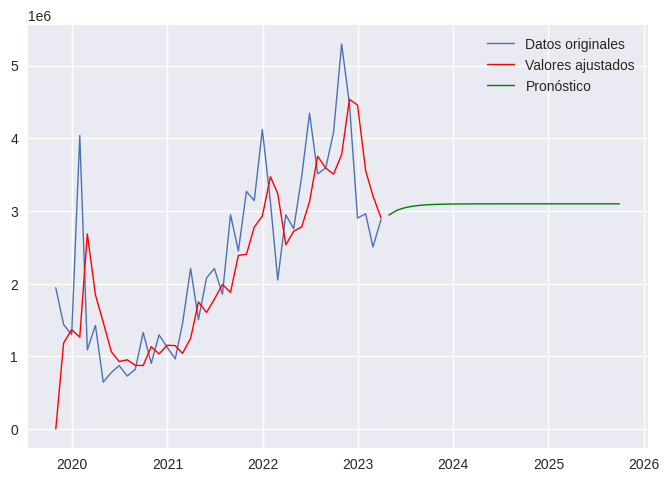

In [33]:
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
# encontrar orden de diferenciación
kpss_diffs = ndiffs(df['cost'], alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(df['cost'], alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

# diferencia la serie de tiempo
diff_data = df['cost'].diff().dropna()

# encontrar orden del modelo ARIMA
model_order = (2, 1, 2) # reemplazar con los valores obtenidos en el punto 7

# ajustar el modelo
model = ARIMA(df['cost'], order=model_order)
results = model.fit()

# predecir valores futuros
forecast = results.forecast(steps=30)

# graficar resultados
plt.plot(df['cost'])
plt.plot(results.fittedvalues, color='red')
plt.plot(forecast, color='green')
plt.legend(['Datos originales', 'Valores ajustados', 'Pronóstico'])
plt.show()